## Packages

In [2]:
# ----- Tensorflow -----
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import regularizers as reg
from keras import optimizers
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

from keras.layers import Input, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, AveragePooling2D, Rescaling, BatchNormalization, Activation, SpatialDropout2D

# ----- Utility functions -----
from utils import load_data, plot_hist, augment_layer, preprocess_data

# ----- Spatial transformer -----
import spatial_transformer as spatial

## Load Data

In [3]:
data_dir = 'C:/Users/chrse/Desktop/project_aml'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=5, batch_size=BATCH_SIZE)

### Architectures
Before we begin building complex architectures for the CNN model, we must establish a baseline classifier which we will attempt to beat. This common-sense baseline will tell us if we are moving in the right direction. In our case, we can choose a simple random classifier with a threshold of 0.5 since we have a binary classification problem where half of the samples belong to class A and the remaining 50% belong to class B. We could also specify a 'simple' machine learning algorithm as a baseline, but although we do not do this explicitly, we will aim to beat the trained models in question 1 as CNNs has some properties that make them superior to non-deep learning algorithms and feedforward neural networks (Chollet, 2021).

At this point, the first thing we want to achieve is statistical power, i.e. to cross the threshold of our baseline classifier by developing a small model. To do so, we focus on parameters such as the loss function, batch_size, learning rate, etc. Due to the way we represent the labels, we will use the softmax activation and the loss function categorical cross entropy rather than sigmoid and binary cross entropy, however, this will not change the results of our models.

Kommentar: Husk arkitektur (størrelse/bredde) og default valg af optimizer (adam) + valgte parametre = default settings + FLOW CHART

In [15]:
# ----- Relatively Simple Convnet from DLPR -----
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()
opt = optimizers.Adam(learning_rate=0.001)
# ----- Configure model -----
model.compile(optimizer=opt,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 30,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 128)       7385

KeyboardInterrupt: 

## Evaluation of simple model

The first results from the experiment with the simple model shows a promising accuracy of 83.xx%, which is significantly higher than the random classifier that has the expected prediction of 50/50. Futhermore, the plots of the accuracy over 30 epochs shows a rather fluctuating accuracy score, which could be an indication of a learning rate that is too high. Thus, for the next step in the procedure, we adjust the learning rate aswell as trying a setting with Stochastic Gradient Descent (SGD) as an alternative optimizer.

According to Goodfellow et al. (2016) perhaps the most important hyperparameter is the learning rate, and if we only had time to tune a single parameter, it should be this one (p. 424). The learning rate controls the speed of the gradient descent process, i.e. how much to adjust the parameters in a single step (Chollet, 2021). If the learning rate is too small, results in too many iterations and the possibility of getting stuck at a local minimum. In contrary, too high of a learning rate could result in divergent behavior. Therefore, we try different values of the learning rate using the Adam optimizer. Due to time constraints of training with different optimizers and learning rates, we will only compare the Adam and (SGD) from Keras. This is reasonable because one... adaptive vs SGD

In [20]:
## Hyperparameters for tuning learning rate and optimizer

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
momentum = [0.99, 0.9]
nesterov = [True, False]

## Optimizer: Adam

Learning rate:  0
Epoch 1/50
82/82 [==============================] - 10s 105ms/step - loss: 0.6945 - accuracy: 0.5689 - val_loss: 0.7623 - val_accuracy: 0.4451
Epoch 2/50
82/82 [==============================] - 9s 104ms/step - loss: 0.6028 - accuracy: 0.6887 - val_loss: 0.5111 - val_accuracy: 0.7713
Epoch 3/50
82/82 [==============================] - 9s 104ms/step - loss: 0.5246 - accuracy: 0.7512 - val_loss: 0.4513 - val_accuracy: 0.8018
Epoch 4/50
82/82 [==============================] - 9s 104ms/step - loss: 0.5036 - accuracy: 0.7638 - val_loss: 0.4410 - val_accuracy: 0.8049
Epoch 5/50
82/82 [==============================] - 5s 63ms/step - loss: 0.4889 - accuracy: 0.7764 - val_loss: 0.4267 - val_accuracy: 0.8049
Epoch 6/50
82/82 [==============================] - 6s 71ms/step - loss: 0.4746 - accuracy: 0.7860 - val_loss: 0.4339 - val_accuracy: 0.8018
Epoch 7/50
82/82 [==============================] - 3s 40ms/step - loss: 0.4542 - accuracy: 0.7932 - val_loss: 0.4485 - val_accurac

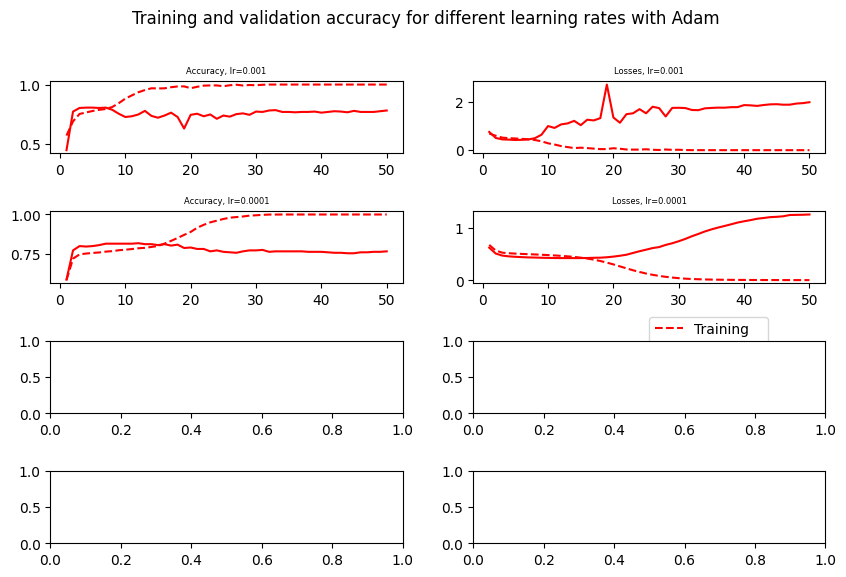

In [21]:
def simple_model():
	inputs = Input(shape=(96, 96, 3))
	x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
	x = Flatten()(x)
	outputs = Dense(2, activation="softmax")(x)
	model = Model(inputs=inputs, outputs=outputs)

	return model

# ----- Define subplot grid -----
t=1
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Training and validation accuracy for different learning rates with Adam", fontsize=12, y=1)

# Try different learning rates for Adam optimizer
for i in range(len(learning_rates)):
	opt = tf.keras.optimizers.Adam(learning_rate=learning_rates[i])

	current_model = simple_model()

	print('Learning rate: ', i)

	# ----- Configure model -----
	current_model.compile(optimizer=opt,
			  	loss='categorical_crossentropy',
			  metrics=['accuracy'])

	# ----- Train model -----
	history = current_model.fit(train,
						epochs=50,
						validation_data=val)

	# ----- Plot performance -----
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(1, len(acc) + 1)

	axis = plt.subplot(4, 2, t)
	axis.plot(epochs, acc,'r--', label='Training')
	axis.plot(epochs, val_acc, 'r', label='Validation')
	axis.set_title('Accuracy, lr=' + str(learning_rates[i]), fontsize=6)

	axis = plt.subplot(4, 2, t+1)
	axis.plot(epochs, loss, 'r--', label='Training')
	axis.plot(epochs, val_loss, 'r', label='Validation')
	axis.set_title('Losses, lr=' + str(learning_rates[i]), fontsize=6)

	t=t+2

plt.legend(loc=(0.5,-1.1))
plt.show()

## Optimizer: SGD

Epoch 1/50
410/410 [==============================] - 38s 91ms/step - loss: 0.6935 - accuracy: 0.5132 - val_loss: 0.6946 - val_accuracy: 0.4969
Epoch 2/50
410/410 [==============================] - 38s 93ms/step - loss: 0.6953 - accuracy: 0.5010 - val_loss: 0.6952 - val_accuracy: 0.4969
Epoch 3/50
410/410 [==============================] - 37s 90ms/step - loss: 0.6955 - accuracy: 0.5050 - val_loss: 0.6959 - val_accuracy: 0.4969
Epoch 4/50
410/410 [==============================] - 37s 90ms/step - loss: 0.6954 - accuracy: 0.5053 - val_loss: 0.6949 - val_accuracy: 0.4969
Epoch 5/50
410/410 [==============================] - 37s 90ms/step - loss: 0.6953 - accuracy: 0.5035 - val_loss: 0.6951 - val_accuracy: 0.4969
Epoch 6/50
410/410 [==============================] - 38s 92ms/step - loss: 0.6954 - accuracy: 0.5024 - val_loss: 0.6950 - val_accuracy: 0.4969
Epoch 7/50
410/410 [==============================] - 38s 94ms/step - loss: 0.6956 - accuracy: 0.5042 - val_loss: 0.6959 - val_accuracy:

KeyboardInterrupt: 

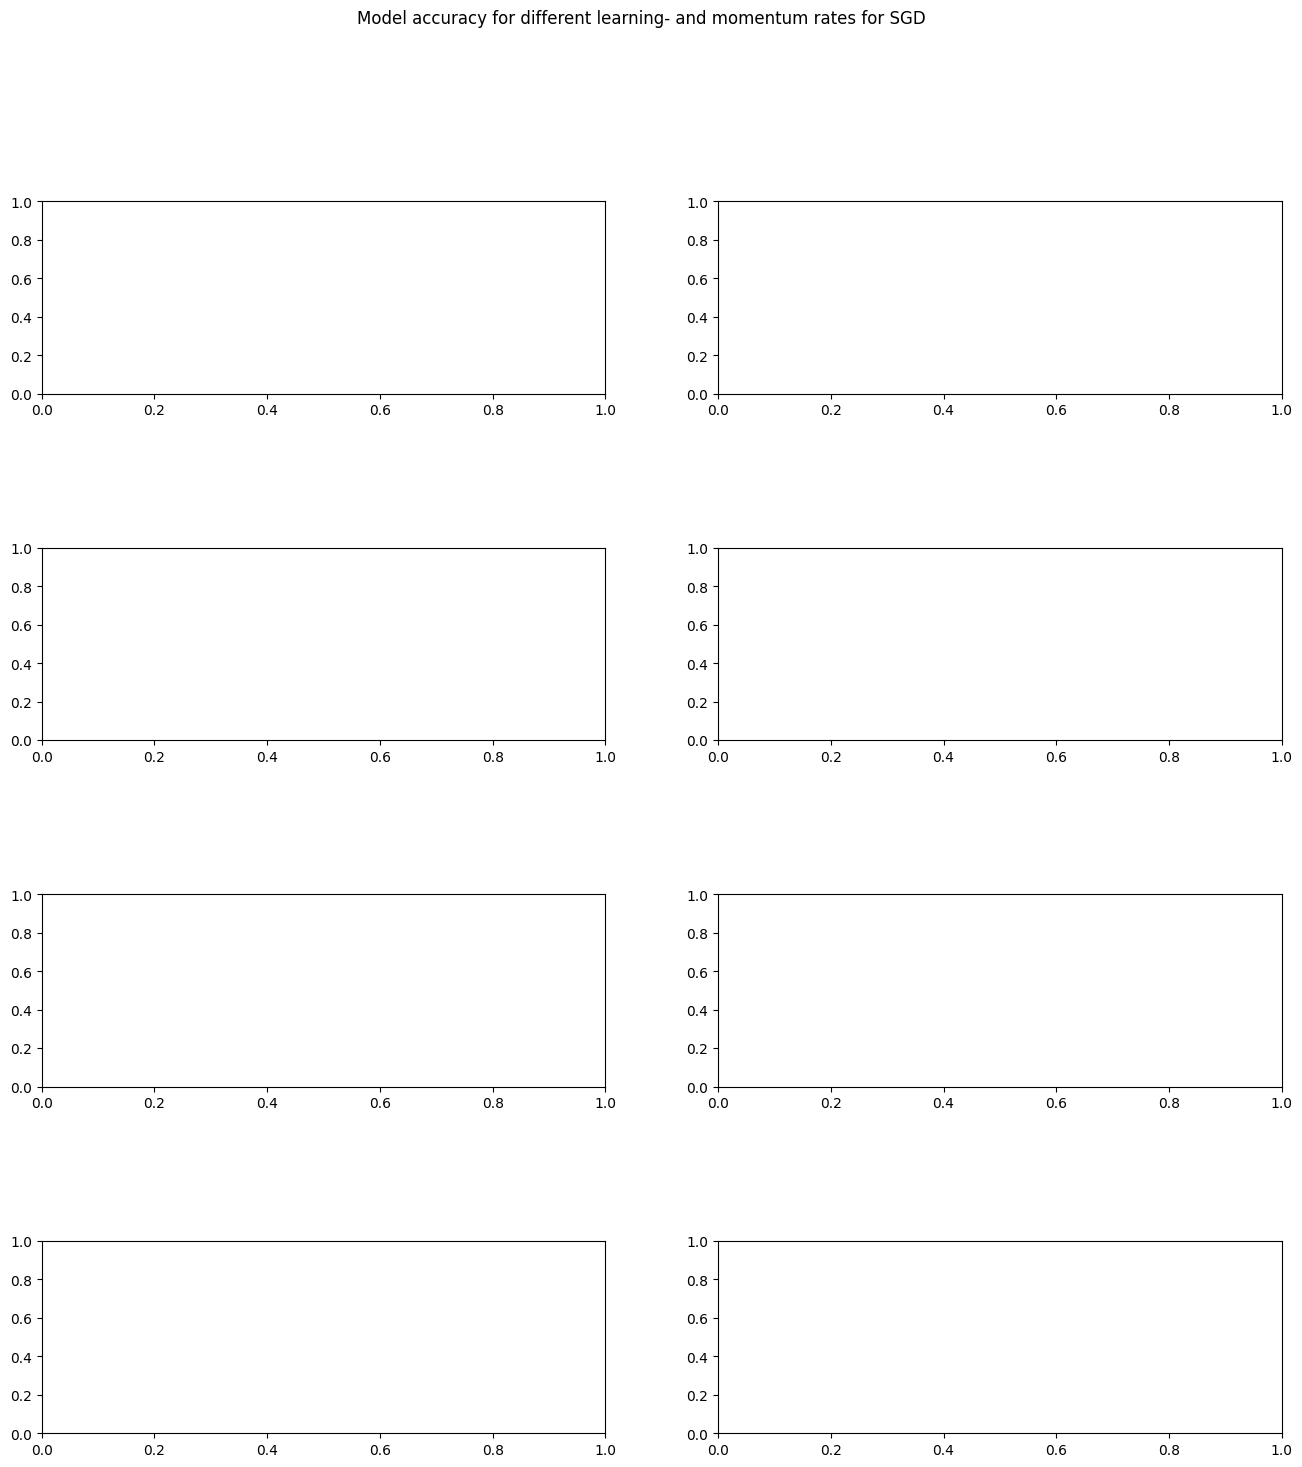

In [12]:
# Try different learning rates, momentum, and nesterov for SGD optimizer
for i in range(len(learning_rates)):
	
	# ----- Define subplot grid -----
	t=1
	fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
	plt.subplots_adjust(hspace=0.8)
	fig.suptitle("Model accuracy for different learning- and momentum rates for SGD", fontsize=12, y=1)

	for m in range(len(momentum)):
		for n in range(len(nesterov)):
			
			current_model = simple_model()

			opt = tf.keras.optimizers.SGD(learning_rate=learning_rates[i],
										  momentum=momentum[m],
										  nesterov=nesterov[n])

			# ----- Configure model -----
			current_model.compile(optimizer=opt,
						loss='categorical_crossentropy',
					metrics=['accuracy'])

			# ----- Train model -----
			history = current_model.fit(train,
								epochs=50,
								validation_data=val)

			# ----- Plot performance -----
			acc = history.history['accuracy']
			val_acc = history.history['val_accuracy']
			loss = history.history['loss']
			val_loss = history.history['val_loss']
			epochs = range(1, len(acc) + 1)

			axis = plt.subplot(4, 2, t)
			axis.plot(epochs, acc,'r--', label='Training')
			axis.plot(epochs, val_acc, 'r', label='Validation')
			axis.set_title('Accuracy, lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]), fontsize=12)

			axis = plt.subplot(4, 2, t+1)
			axis.plot(epochs, loss, 'r--', label='Training')
			axis.plot(epochs, val_loss, 'r', label='Validation')
			axis.set_title('Losses, lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]), fontsize=12)
			t=t+2
	plt.legend(loc=(0.7,-0.5))
	plt.savefig('lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]) + '.png')
	plt.show()
	


## Evaluation of learning rates and momentum for Adam and SGD



In [14]:
Best_optimizer = optimizers.Adam(learning_rate=0.0001)

## Regularization 1: Adjustments to the architecture

- Add/remove layers
- Adjust number of nodes

Deeper + narrower model

In [23]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(inputs) # Filters 16 instead of 32
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)     # Extra dense layer with 64 filters
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)											# Extra dense layer
x = Dense(128, activation="relu")(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 30,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 24, 24, 64)        1849

KeyboardInterrupt: 

Smaller model

Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_348 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_280 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_349 (Conv2D)         (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_281 (MaxPooli  (None, 22, 22, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_350 (Conv2D)         (None, 20, 20, 128)       738

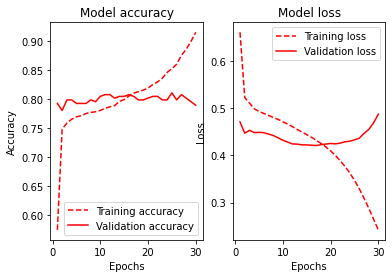

In [33]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x) #Pooling layer removed and amount of filters set to 128
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 30,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Evaluation of architectures

## Increase amount of data

In [24]:
data_dir = 'C:/Users/chrse/Desktop/project_aml'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=10, batch_size=BATCH_SIZE)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 20, 20, 128)       738

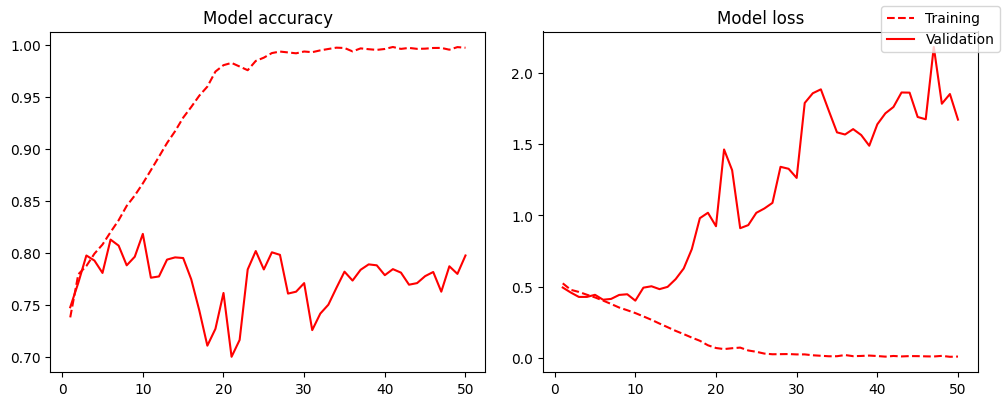

In [25]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Regularization: Introduction

Regarding early stopping, we prefer to save the best model instead and let the model train for the chosen epochs.

- Augmentation
- L1/L2
- Batch normalization
- Dropout



# Best model
# ----- Relatively Simple Convnet from DLPR -----
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

def augment_layer(size: Optional[int] = None,
                 flip: Optional[Literal["horizontal_and_vertical", "horizontal", "vertical"]] = None,
                 rotation: Optional[float] = None,
                 zoom: Optional[tuple[float, float]] =,
                 contrast: Optional[float] = None,
                 brightness: Optional[float] = None) -> layers:

## Regularization: Augmentation

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856 

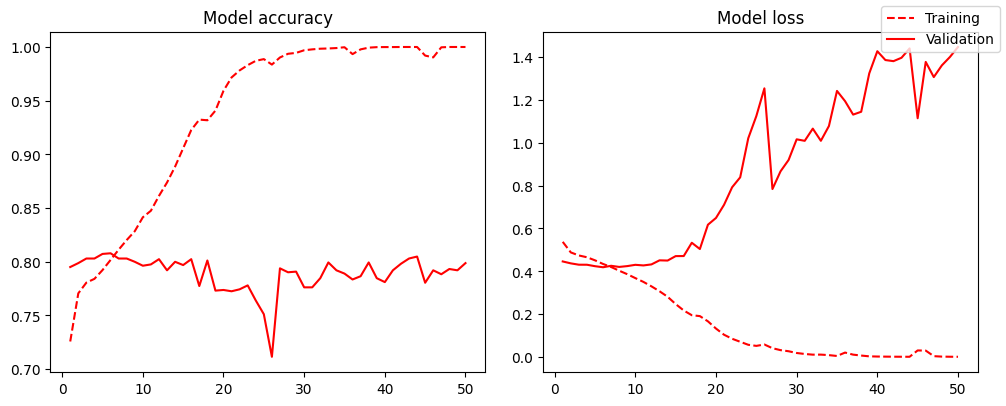

In [4]:
# Augmentation

inputs = Input(shape=(96, 96, 3))
x = augment_layer(flip="horizontal_and_vertical", rotation=180, contrast=0.2, brightness=0.05)
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Regularization: L1 and L2

In [5]:
l_reg_values = [0.001, 0.01]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 20, 128)       7385

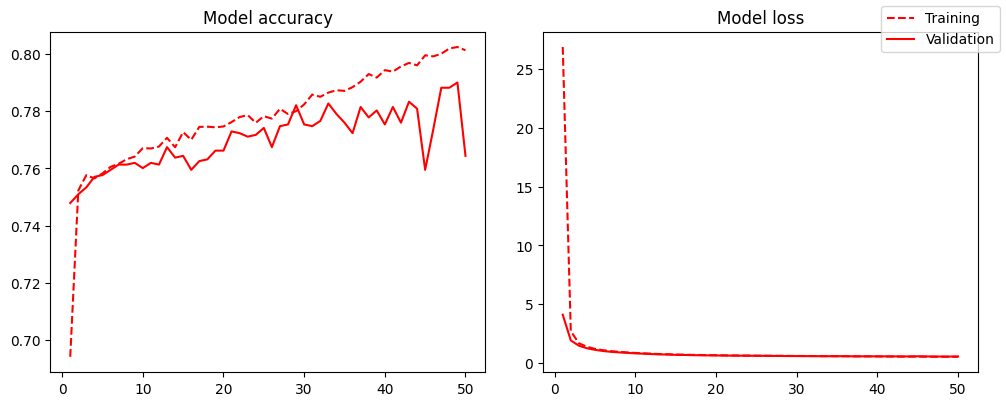

In [6]:
# L1 Low reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 20, 20, 128)       7385

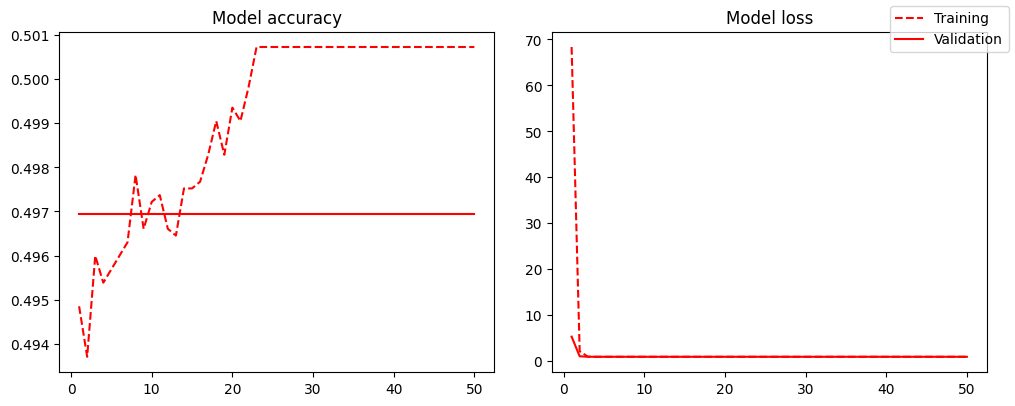

In [10]:
# L1 High reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(inputs)
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = Flatten()(x)


    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 20, 20, 128)       738

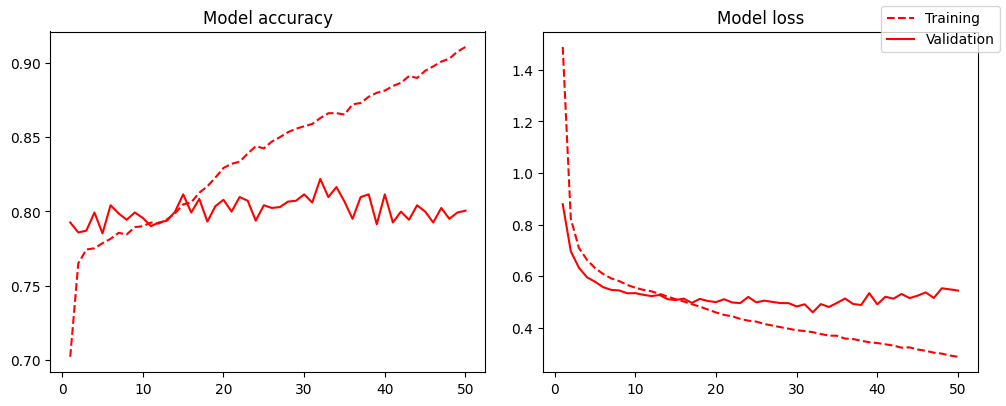

In [11]:
# L2 low reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 20, 20, 128)       738

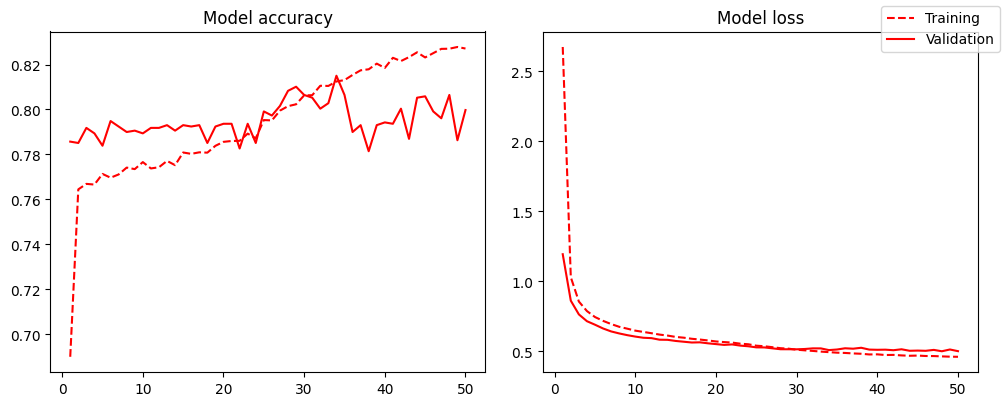

In [12]:
# L2 high reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(inputs)
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = Flatten()(x)


    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Regularization: Batch normalization 

Batch normalization is added and tested in three different ways:

1. Batch normalization is not included
2. Batch normalization

In [ ]:


x = BatchNormalization()(x) # HUSK kommentar om activation function før/efter batch normalization
x = Activation('relu')(x)

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, kernel_regularizer=reg.L2(i))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

In [ ]:
x = BatchNormalization()(x) # HUSK kommentar om activation function før/efter batch normalization
x = Activation('relu')(x)

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, kernel_regularizer=reg.L2(i))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Regularization: Dropout

In [36]:
dropout_values = [0.2, 0.4]

#### Setup 1 

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_377 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_302 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_378 (Conv2D)         (None, 45, 45, 64)        18496     
                                                                 
 spatial_dropout2d_7 (Spatia  (None, 45, 45, 64)       0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_303 (MaxPooli  (None, 22, 22, 64)       0  

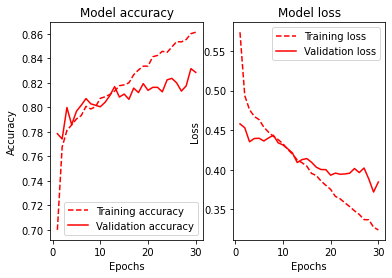

In [43]:
for i in dropout_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = SpatialDropout2D(i)(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = SpatialDropout2D(i)(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

    # ----- Model summary -----
    model.summary()

    # ----- Configure model -----
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # ----- Train model -----
    history = model.fit(train,
                        epochs = 50,
                        validation_data= val)

    # ----- Plot performance -----
    plot_hist(history)

#### Setup 2

In [ ]:
for i in dropout_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = SpatialDropout2D(i)
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = SpatialDropout2D(i)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = SpatialDropout2D(i)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = SpatialDropout2D(i)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)
    x = Dropout(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

#### Setup 3

# ----- Relatively Simple Convnet from DLPR -----
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer='adam',
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 2,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

First model = Simple CNN from DLWP --> 